In [34]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
from skbio.tree import TreeNode
from itertools import combinations
from scipy.stats import mannwhitneyu
from skbio.stats.distance import mantel
from glob import glob
from os.path import join, basename
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

from ggmap.snippets import *
from ggmap.analyses import *
from ggmap.correlations import *
from ggmap.workflow import *
import calour as ca
ca.set_log_level(40)
import io

import requests
import json
import fetch
from ggmap.tree import *
from ggmap.utils import *
from ggmap.readwrite import *

from scipy.spatial import distance
from scipy.cluster import hierarchy

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [81]:
def _savefig(fig, name):
    os.makedirs('Figures_generated/SVG', exist_ok=True)
    os.makedirs('Figures_generated/PNG', exist_ok=True)
    
    fig.savefig('Figures_generated/SVG/%s.svg' % name, bbox_inches='tight')
    fig.savefig('Figures_generated/PNG/%s.png' % name, bbox_inches='tight')
    
keggmap = {
    'DL-Glutamine__146.06889__2.661': 'C00064',
    '2-Oxoglutaric acid__146.02129__15.709': 'C00026',
    'Phosphoenolpyruvic acid__167.98221__15.803': 'C00074',
    'D-Erythrose 4-phosphate__200.00854__10.933': 'C00279',
    '(4R,5R)-2,3,4,5-Tetrahydroxy-5-(hydroxymethyl)-2-cyclohexen-1-one__190.04766__11.144': 'C00944',
    '1,3,4-Trihydroxy-5-oxocyclohexanecarboxylic acid__190.04765__3.576': 'C00944',
    '4,5-Dihydroxy-3-oxo-1-cyclohexene-1-carboxylic acid__172.03705__17.561': 'C02637',
    '4,5-Dihydroxy-3-oxo-1-cyclohexene-1-carboxylic acid__172.03705__15.705': 'C02637',
    'Dimethyl 3-oxoglutarate__174.05262__3.905': 'C00493',
}

In [19]:
counts = dict()
meta = pd.read_excel("Incoming/Serum samples for bacterial metabolites analysis - sent on 13-01-2020.xlsx", sheet_name="Murine serum samples").rename(columns={'tube_number': 'sample_name'})
meta['sample_name'] = meta['sample_name'].astype(str)
meta = meta.set_index('sample_name')

x = pd.read_excel('Incoming/200225__Data_20-0005.xlsx', sheet_name="01.AllData").rename(columns={'Sample.label.on.tube': 'sample_name'})
x['sample_name'] = x['sample_name'].astype(str)
data = x[['sample_name', "Compound", "ISTD", "Resp", "ISTD.Resp", "Resp.Ratio", "UserAnno.Peak", "MI.Peak", "MZ", "MZ.Ex.Left", "MZ.Ex.Right", "MZ.Ex.Units", "RT.Compound", "RT.Peak", "MS.Replicates", "data.source", "ISTD.Resp.Ratio", "Acq.Method.Condensed", "MS.project", "Report.Name", "data.dir", "relativeResponse", "IQR_1.5_outlier"]].set_index(['sample_name', 'Compound'])
counts['GC-MS'] = pd.pivot_table(data=data, columns='sample_name', index="Compound", values="relativeResponse").fillna(0)

x = pd.read_excel("Incoming/20-0005_IC-MS_results_filtered.xlsx", sep="\t")
x['Compound'] = x['Name'].fillna('Unknown') + '__' + x['Molecular Weight'].astype(str) + "__" + x['RT [min]'].astype(str)
# attention: I am guessing here how to map sample names. I don't understand why we cannot use ONE set of samplenames throught the different measurements :-/
sample_id_map = {c: c.split('(')[-1][1:-1] for c in x.columns if c.startswith('Norm. Area: 20-0005_')}
x = x.rename(columns=sample_id_map)
counts['IC-MS'] = x[['Compound'] + sorted(list(sample_id_map.values()))].set_index('Compound')
counts['IC-MS'].columns.name = 'sample_name'

# normalize IC and GC to 0-1 intervals and merge
counts['IC+GC-MS'] = pd.concat([(counts[method] - counts[method].min().min()) / (counts[method].max().max() - counts[method].min().min())
                                for method in ['IC-MS', 'GC-MS']], sort=False, join='inner') * 10000


# Philipps targeted Analysis
for group in ['putative_SCFA', 'nucleotide_turnover', 'chorismate_pathway']:
    x = pd.read_excel('Incoming/20-0005_%s.xlsx' % group)
    x['Compound'] = x['Name'].fillna('Unknown') + '__' + x['Molecular Weight'].astype(str) + "__" + x['RT [min]'].astype(str)
    # attention: I am guessing here how to map sample names. I don't understand why we cannot use ONE set of samplenames throught the different measurements :-/
    sample_id_map = {c: c.split('(')[-1][1:-1] for c in x.columns if c.startswith('Norm. Area: 20-0005_')}
    x = x.rename(columns=sample_id_map)
    counts[group] = x[['Compound'] + sorted(list(sample_id_map.values()))].set_index('Compound')
    counts[group].columns.name = 'sample_name'
    counts[group] = counts[group].fillna(0)

In [24]:
res_alpha = dict()
res_beta = dict()
res_emperor = dict()
res_corr = dict()
sig_cols = dict()

cols_toCheck = ["genotype", "antibiotics_treatment_start_timestamp", "facility", "diseased", "cage", "sex"]
for method in counts.keys():
    res_alpha[method] = alpha_diversity(counts[method], metrics=['shannon'], dry=False, wait=False, rarefaction_depth=None)
    if res_alpha[method]['results'] is not None:
        res_alpha[method]['results'].index = list(map(str, res_alpha[method]['results'].index))

    res_beta[method] = beta_diversity(counts[method], metrics=['bray_curtis', 'jaccard'], dry=False, wait=False)
    if res_beta[method]['results'] is not None:
        res_emperor[method] = emperor(meta, res_beta[method]['results'], fp_results="./Emperor/", dry=False, wait=False, infix='_%s' % method)

    if res_alpha[method]['results'] is not None and res_beta[method]['results'] is not None:
        res_corr[method] = correlation_diversity_metacolumns(meta, cols_toCheck, res_alpha[method]['results'], res_beta[method]['results'],
                                                                 dry=False, wait=False)
        if (res_corr[method] is not None) and (res_corr[method]['results'] is not None):
            for col in cols_toCheck:
                sig_cols[(method, col)] = res_corr[method]['results'][res_corr[method]['results']['column'] == col]['p-value'].min() <= 0.05
sig_cols = pd.pivot_table(data=pd.Series(sig_cols).to_frame().reset_index(), index='level_1', columns='level_0', values=0)

res_mantel = dict()
for (methodA, methodB) in combinations(counts.keys(), 2):
    _ = emperor(meta, res_beta[methodA]['results'], fp_results="./Emperor/", other_beta_diversities=res_beta[methodB]['results'], dry=False, wait=False, infix='_%s-%s' % (methodA, methodB), use_grid=True)
    for metric in res_beta[methodA]['results'].keys():
        if metric == 'jaccard':
            # jaccard doesn't make sense, since all compounds are always non zero, i.e. distances are always 0
            continue
        res_mantel[(metric, methodA, methodB)] = mantel(res_beta[methodA]['results'][metric], res_beta[methodB]['results'][metric], strict=False)
res_mantel = pd.DataFrame(res_mantel).T.rename(columns={0: 'corr_coeff', 1: 'p_value', 2: 'n'})

print("Significantly (<=0.05) correlating metadata fields with metabolome:")
display(sig_cols)
print("Mantel correlation between metabolome measures:")
display(res_mantel)

Using existing results from '.anacache/863d46e0d0daa2981a9ec1cbeaf5d11d.adiv'. 
Using existing results from '.anacache/8a60d661a77d7f0c480e7eb4d518879b.bdiv'. 
Using existing results from '.anacache/89d2d00cebfc683218742337414a4c74.emperor'. 
Using existing results from '.anacache/c8b0b77a0a5c9219e0ac1818ec75da75.corr-divmeta'. 
Using existing results from '.anacache/1c2afeda8d80a180454df89de855858a.adiv'. 
Using existing results from '.anacache/988d44d19aea5ba3a517f8200dc42f2f.bdiv'. 
Using existing results from '.anacache/e212395b81815839e0c3512b366d2a46.emperor'. 
Reducing analysis to 30 samples.
Using existing results from '.anacache/920e18aeea69c46739206247432fac19.corr-divmeta'. 
Using existing results from '.anacache/142489ab8fb2b1c2e81c3acd71eb0a4e.adiv'. 
Using existing results from '.anacache/08d4d171811ff4a41668a5e151b05008.bdiv'. 
Using existing results from '.anacache/2ef44d1804f14f5fba222c8e54dbc416.emperor'. 
Using existing results from '.anacache/d37e7046e5071ba36c50ff3

Significantly (<=0.05) correlating metadata fields with metabolome:


level_0,GC-MS,IC+GC-MS,IC-MS,chorismate_pathway,nucleotide_turnover,putative_SCFA
level_1,,,,,,
antibiotics_treatment_start_timestamp,True,True,True,True,True,True
cage,True,True,True,True,True,True
diseased,True,True,True,True,True,True
facility,False,False,False,False,False,False
genotype,True,True,True,True,True,True
sex,False,False,False,False,False,False


Mantel correlation between metabolome measures:


corr_coeff  p_value     n
bray_curtis GC-MS               IC-MS                  0.529546    0.001  30.0
                                IC+GC-MS               0.843608    0.001  30.0
                                putative_SCFA          0.718494    0.001  30.0
                                nucleotide_turnover    0.523246    0.001  30.0
                                chorismate_pathway     0.163728    0.152  30.0
            IC-MS               IC+GC-MS               0.890655    0.001  30.0
                                putative_SCFA          0.815089    0.001  37.0
                                nucleotide_turnover    0.956678    0.001  37.0
                                chorismate_pathway     0.764902    0.001  37.0
            IC+GC-MS            putative_SCFA          0.779400    0.001  30.0
                                nucleotide_turnover    0.843477    0.001  30.0
                                chorismate_pathway     0.445558    0.002  30.0
            putative_SCFA       nucleotide_turnover    0.909652    0.001  37.0
                                chorismate_pathway     0.850892    0.001  37.0
            nucleotide_turnover chorismate_pathway     0.827122    0.001  37.0

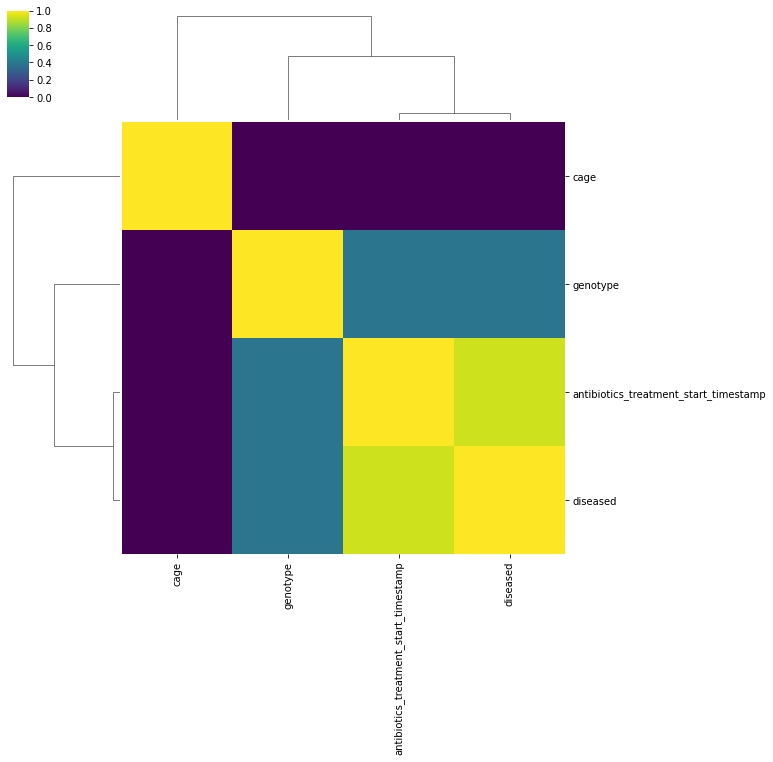

In [5]:
fields_categorials = ["genotype", "antibiotics_treatment_start_timestamp", "diseased", "cage"]
fields_intervals = []
fields_ordinals = {}
res_corr_meta = correlate_metadata(meta.loc[:, cols_toCheck], fields_categorials, fields_ordinals, fields_intervals)
res_corr_meta[0]

Using existing results from '.anacache/b1e430662bef7417c443ee2028d94bad.fRDAalpha'. 
No significant findings.
Using existing results from '.anacache/2551ddf57450bd71a150734c5befaeda.fRDAbeta'. 
Using existing results from '.anacache/d5af414900e73283a745a0421be93648.fRDAalpha'. 
No significant findings.
Using existing results from '.anacache/f0e75223ea96c72792fdf4b253048834.fRDAbeta'. 
Using existing results from '.anacache/f9b91f74c02c0fdea7cd2a9a63fef232.fRDAalpha'. 
No significant findings.
Using existing results from '.anacache/6d30962884fdf968a052776cfdb5f90d.fRDAbeta'. 
found matching working dir "/homes/sjanssen/TMP/ana_fRDAalpha_hfhgz6uw"
 Was removed.
No significant findings.
found matching working dir "/homes/sjanssen/TMP/ana_fRDAbeta_kcyqxlg9"
No significant covariates found!
 Was removed.
No significant findings.
found matching working dir "/homes/sjanssen/TMP/ana_fRDAalpha_4ykbj2sb"
 Was removed.
No significant findings.
found matching working dir "/homes/sjanssen/TMP/ana_f

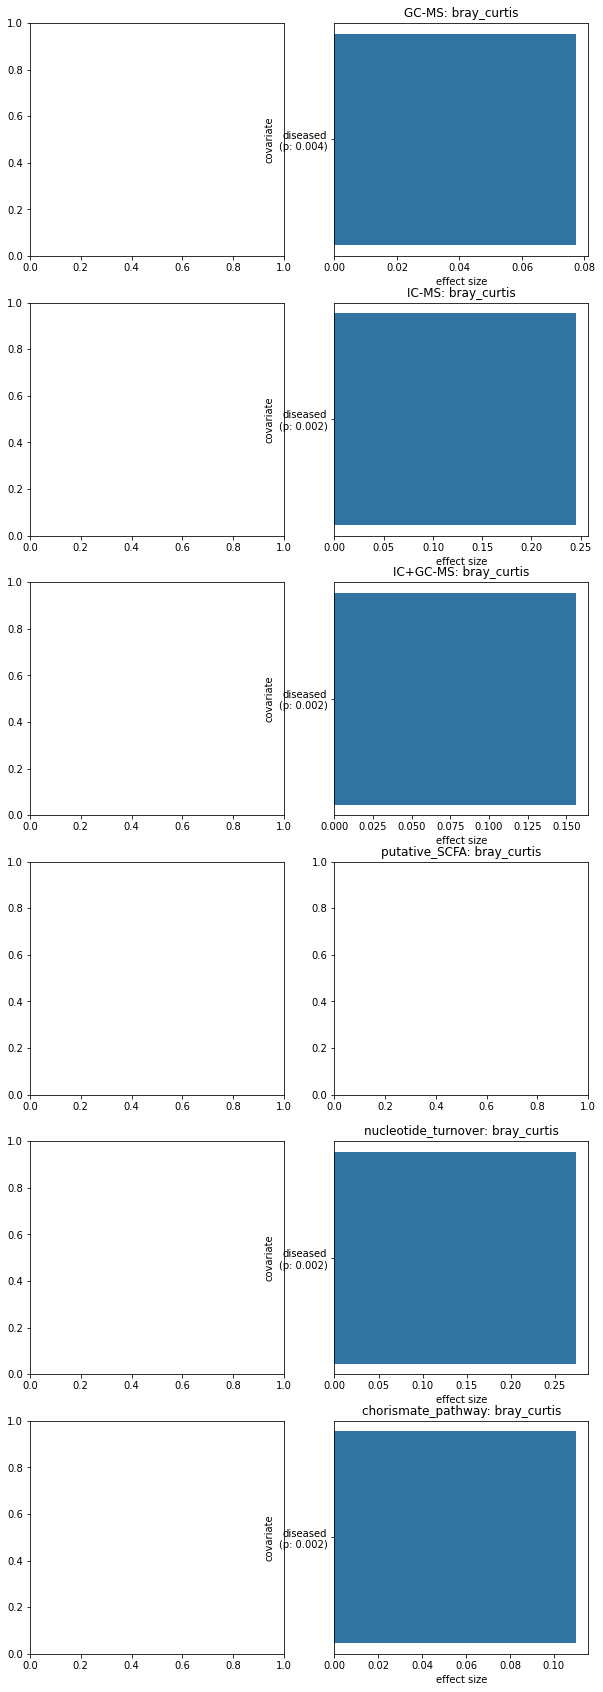

In [26]:
fields = ["diseased", "genotype"]
#fields = [c for c,r in (sig_cols.sum(axis=1) == sig_cols.shape[1]).iteritems() if r]

fig, axes = plt.subplots(len(counts.keys()), 2, figsize=(5*2, 5*len(counts.keys())))
for i, method in enumerate(counts.keys()):
    metric = 'shannon'
    _ = redundancy_analysis_alpha(meta, res_alpha[method]['results'][metric],
                                  categorials=fields, 
                                  ax=axes[i][0], title=metric,
                                  dry=False, wait=False)
    
    metric = 'bray_curtis'
    _ = redundancy_analysis_beta(meta, res_beta[method]['results'][metric], metric,
                                 categorials=fields, 
                                 ax=axes[i][1], title=metric,
                                 dry=False, wait=False)
    axes[i][1].set_title('%s: %s' % (method, metric))
fig

## Specific analyses

In [27]:
e = dict()

fp_meta = 'Workdir/metabolome_diffabund_meta.tsv'
meta.to_csv(fp_meta, sep="\t", index=True)
for method in res_beta.keys():
    fp_diffabund = 'Workdir/metabolome_diffabund_%s.biom' % method
    pandas2biom(fp_diffabund, counts[method])
    e[method] = ca.read_amplicon(fp_diffabund, fp_meta, min_reads=0, normalize=10000)

### Non-diseased animals: difference WT vs. Pax5+/-

In [28]:
for method in res_beta.keys():
    p = plotNetworks("genotype", meta[meta['diseased'] == 'no'], res_alpha[method]['results'], {k: v for k,v in res_beta[method]['results'].items() if k == 'bray_curtis'}, minnumalpha=5, name='%s: genotype' % method)

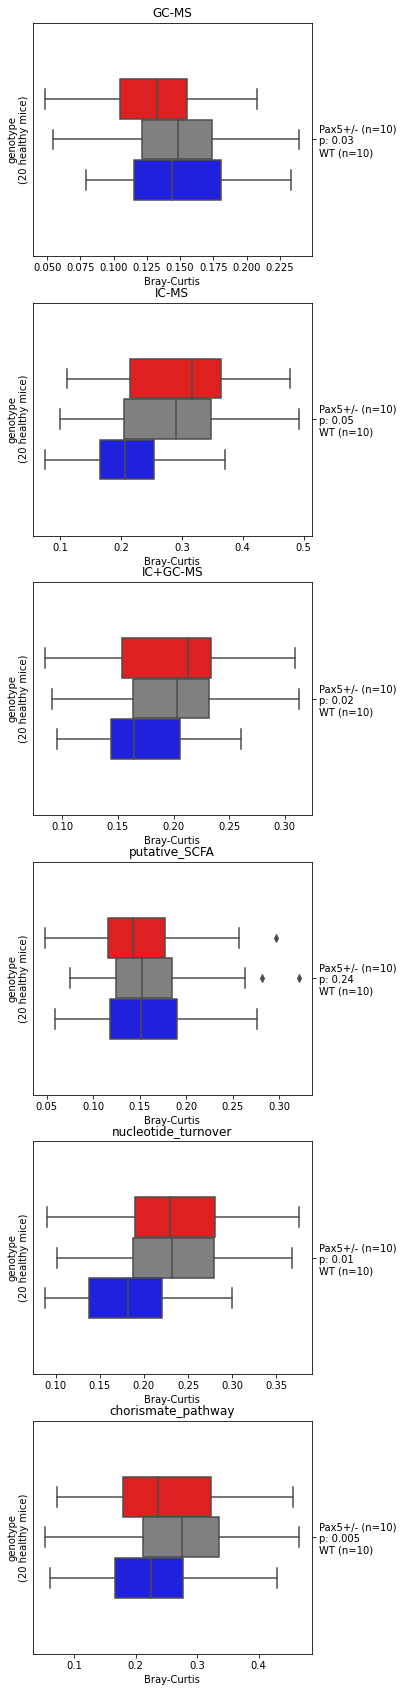

In [35]:
fig, axes = plt.subplots(len(counts.keys()),1, figsize=(1*5, len(counts.keys())*5))
for i, method in enumerate(res_beta.keys()):
    field = 'genotype'
    field_meta = meta[meta['diseased'] == 'no'][field]
    b = detect_distant_groups(res_beta[method]['results']['bray_curtis'], 'Bray-Curtis', field_meta)
    ax, _ = plotGroup_permanovas(res_beta[method]['results']['bray_curtis'], field_meta, **b,
                                 horizontal=True, print_sample_numbers=True, colors_boxplot={'between': 'gray', 'left': 'red', 'right': 'blue'}, ax=axes[i])
    ax.set_ylabel(field+ "\n(%i healthy mice)" % field_meta.shape[0])
    ax.yaxis.label.set_visible(True)
    ax.set_title(method)
_savefig(fig, 'metabolome_beta_genotype')

/homes/sjanssen/miniconda3/envs/notebookServer/lib/python3.7/site-packages/pandas/core/indexing.py:1418: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


'genotype'  (n=30)
     5 (of   56) taxa different between 'WT' (n=10) vs. 'Pax5+/-' (n=10)



/homes/sjanssen/miniconda3/envs/notebookServer/lib/python3.7/site-packages/pandas/core/indexing.py:1418: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


'genotype'  (n=37)
   107 (of  217) taxa different between 'WT' (n=10) vs. 'Pax5+/-' (n=10)



/homes/sjanssen/miniconda3/envs/notebookServer/lib/python3.7/site-packages/pandas/core/indexing.py:1418: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


'genotype'  (n=30)
   117 (of  273) taxa different between 'WT' (n=10) vs. 'Pax5+/-' (n=10)



/homes/sjanssen/miniconda3/envs/notebookServer/lib/python3.7/site-packages/pandas/core/indexing.py:1418: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


'genotype'  (n=37)
   112 (of  616) taxa different between 'WT' (n=10) vs. 'Pax5+/-' (n=10)



/homes/sjanssen/miniconda3/envs/notebookServer/lib/python3.7/site-packages/pandas/core/indexing.py:1418: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


'genotype'  (n=37)
    89 (of  183) taxa different between 'WT' (n=10) vs. 'Pax5+/-' (n=10)



/homes/sjanssen/miniconda3/envs/notebookServer/lib/python3.7/site-packages/pandas/core/indexing.py:1418: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


'genotype'  (n=37)
     4 (of    9) taxa different between 'WT' (n=10) vs. 'Pax5+/-' (n=10)



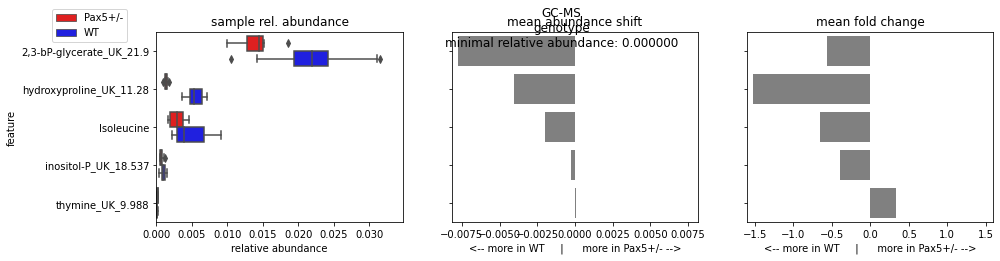

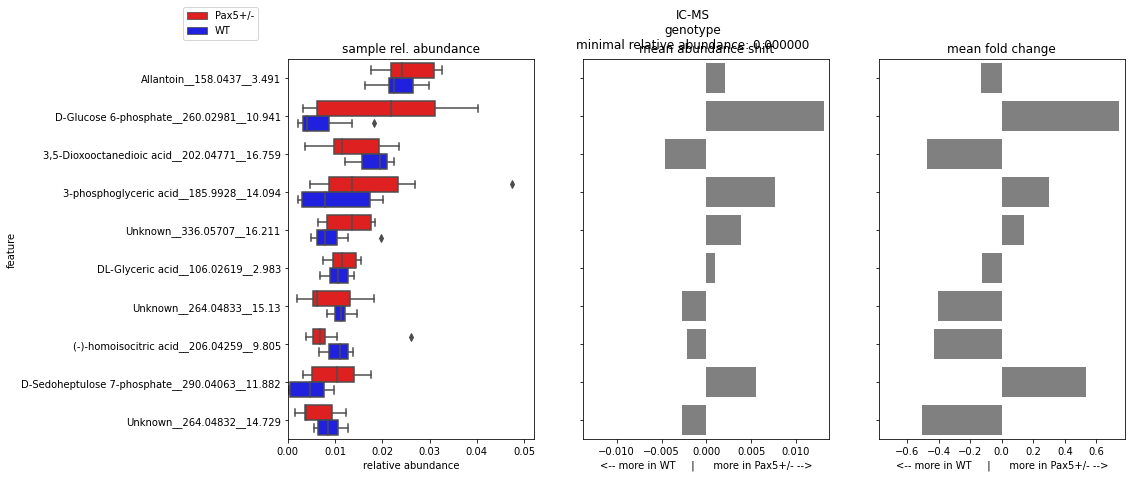

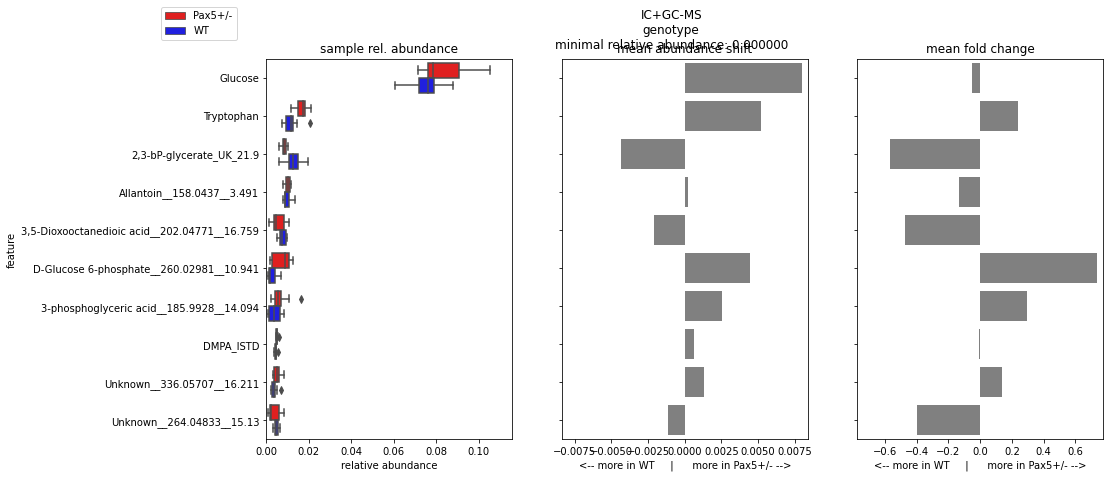

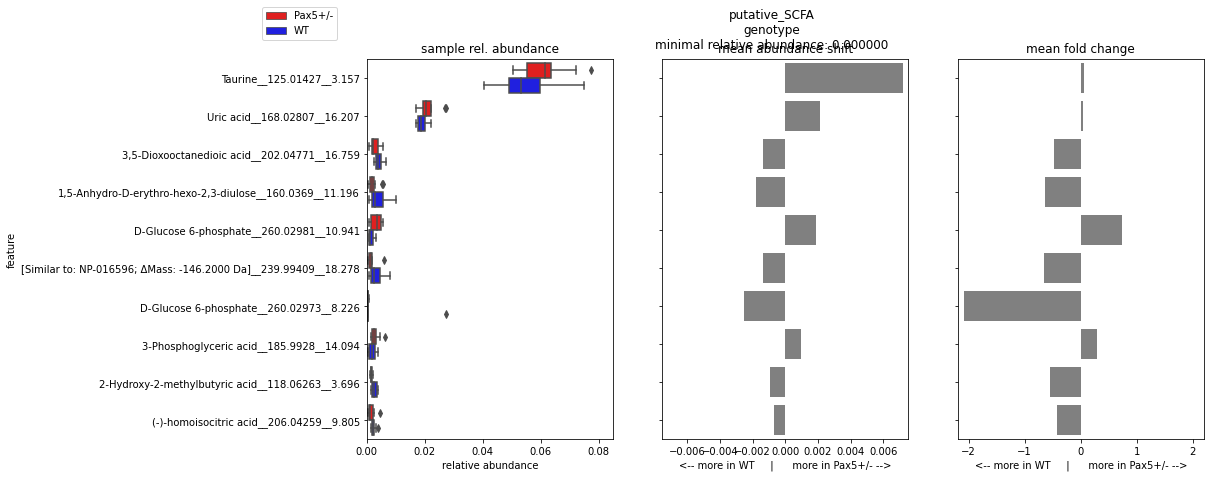

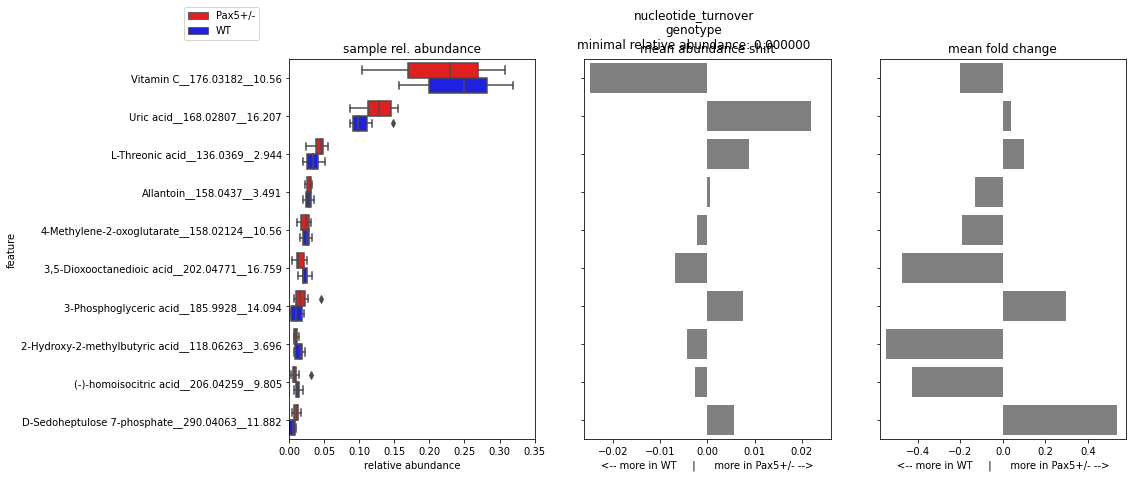

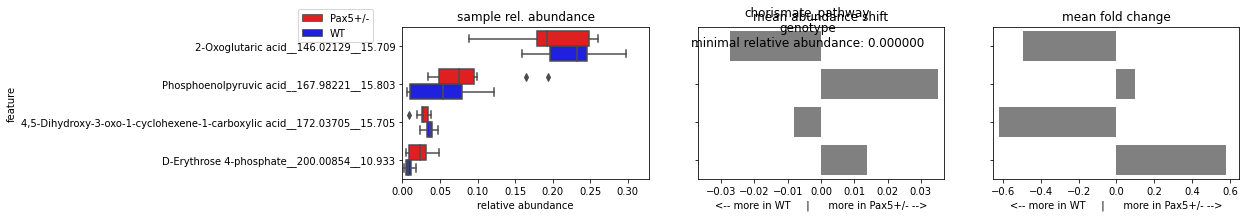

In [49]:
found_compounds = []

for method in res_beta.keys():
    field = 'genotype'
    res_dsFDR_genotype = find_diff_taxa(e[method], meta[meta['diseased'] == 'no'], [field])
    p = plot_diff_taxa(counts[method], meta[meta['diseased'] == 'no'][field], res_dsFDR_genotype,
                       min_mean_abundance=0.0, title=method, topXfeatures=10,
                       colors_boxplot={'Pax5+/-': 'red', 'WT': 'blue'}, color_barplot='gray')
    _savefig(p[0], 'metabolome_dsfdr_genotype_%s' % method)
    found_compounds.extend([{'compound': x.get_text(), 'method': method, 'group': field, 'found': 1} for x in p[0].axes[0].get_yticklabels()])

### Pax5+/- animals: sick vs. healthy

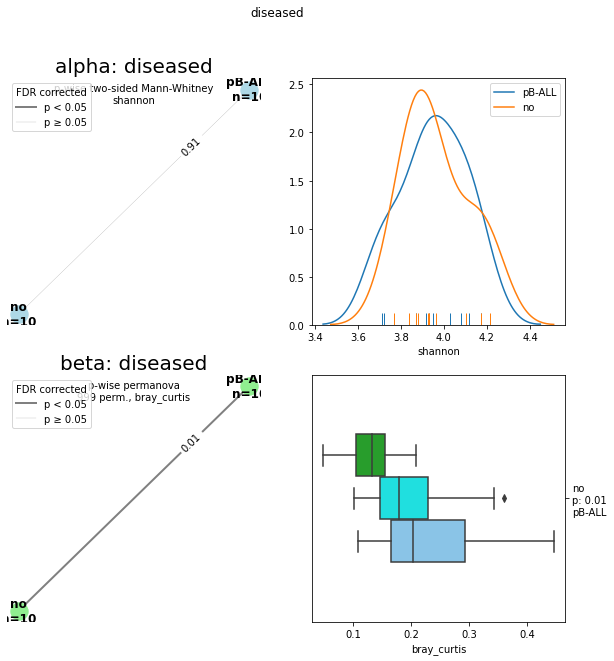

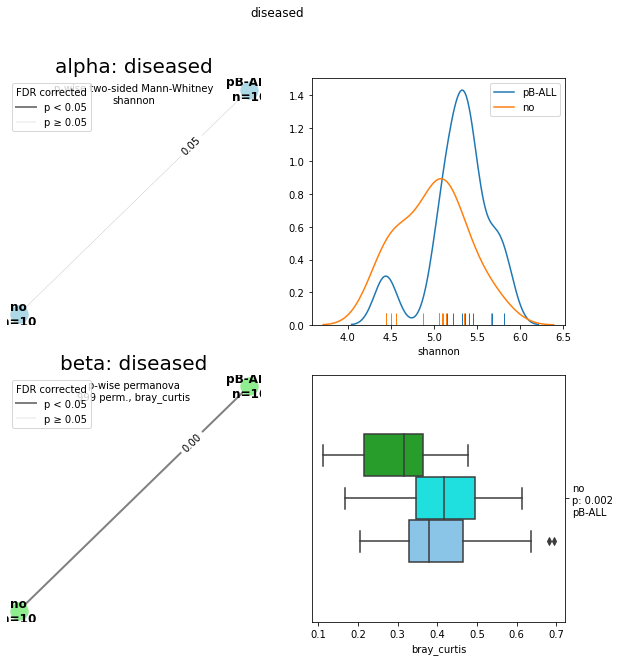

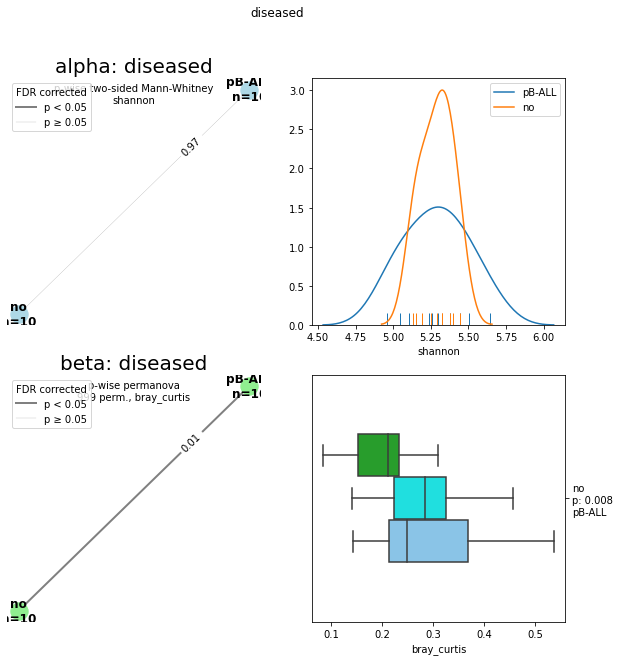

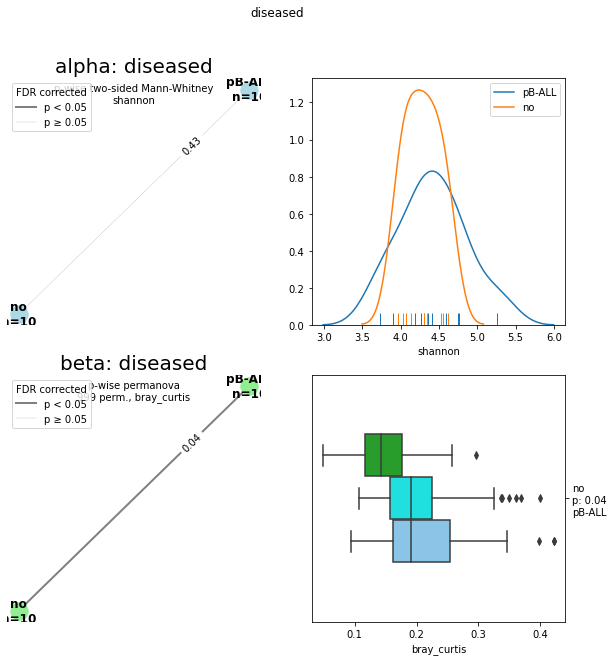

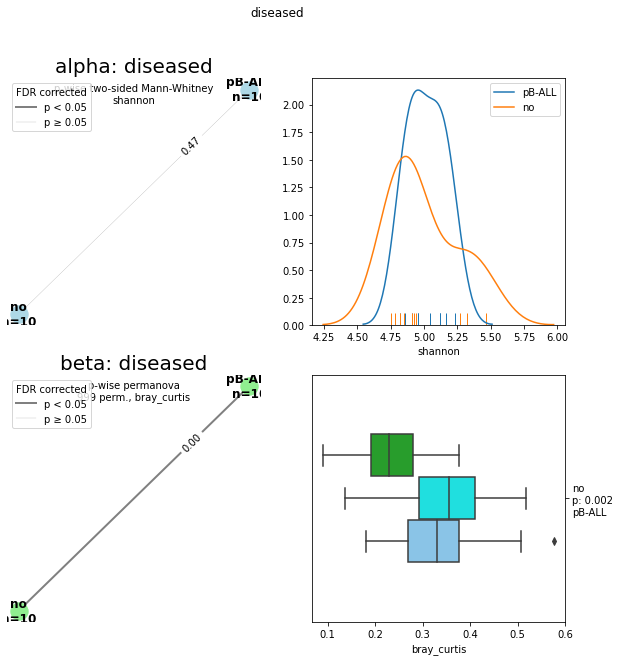

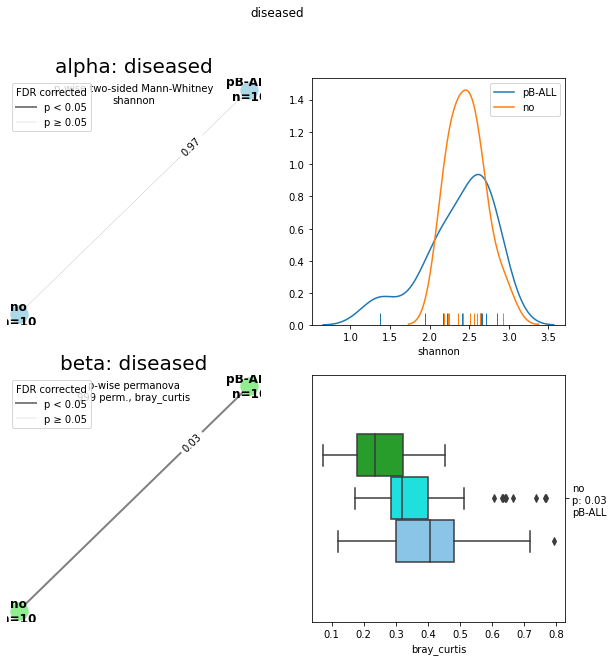

In [37]:
for method in res_beta.keys():
    p = plotNetworks("diseased", meta[meta['genotype'] == 'Pax5+/-'], res_alpha[method]['results'], {k: v for k,v in res_beta[method]['results'].items() if k == 'bray_curtis'}, minnumalpha=5, name='diseased')
    #_savefig(p, 'network_diseased')

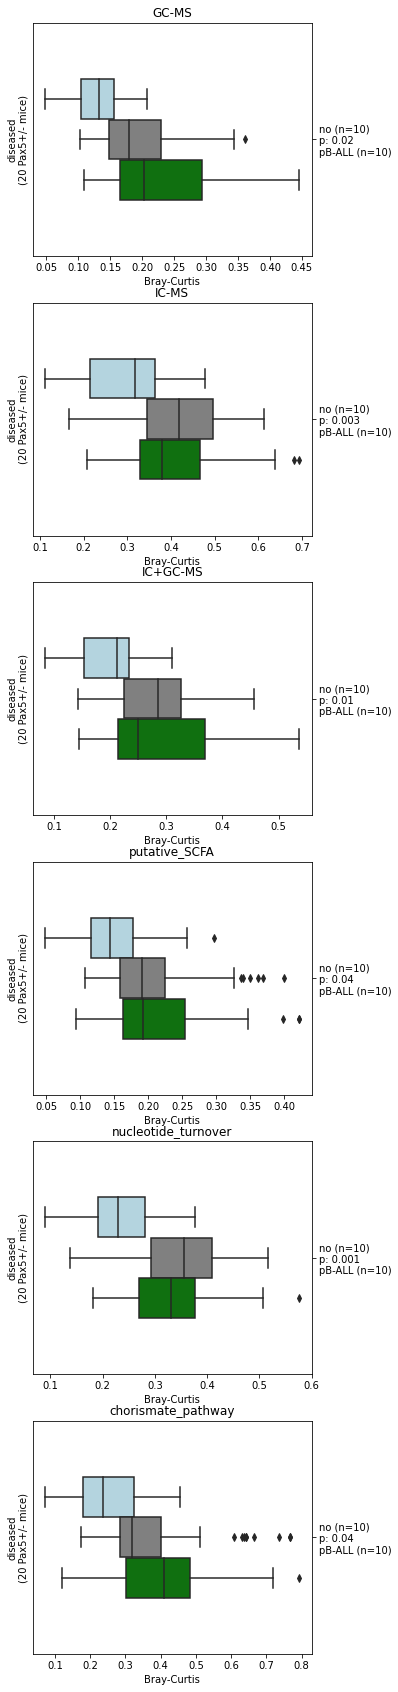

In [39]:
fig, axes = plt.subplots(len(counts.keys()),1, figsize=(1*5, len(counts.keys())*5))
for i, method in enumerate(res_beta.keys()):
    field = 'diseased'
    field_meta = meta[meta['genotype'] == 'Pax5+/-'][field]
    b = detect_distant_groups(res_beta[method]['results']['bray_curtis'], 'Bray-Curtis', field_meta)
    ax, _ = plotGroup_permanovas(res_beta[method]['results']['bray_curtis'], field_meta, **b,
                                 horizontal=True, print_sample_numbers=True, colors_boxplot={'between': 'gray', 'left': 'lightblue', 'right': 'green'}, ax=axes[i])
    ax.set_ylabel(field+ "\n(%i Pax5+/- mice)" % field_meta.shape[0])
    ax.yaxis.label.set_visible(True)
    ax.set_title(method)
_savefig(fig, 'metabolome_beta_disease')

/homes/sjanssen/miniconda3/envs/notebookServer/lib/python3.7/site-packages/pandas/core/indexing.py:1418: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


'diseased'  (n=30)
    17 (of   56) taxa different between 'pB-ALL' (n=10) vs. 'no' (n=10)



/homes/sjanssen/miniconda3/envs/notebookServer/lib/python3.7/site-packages/pandas/core/indexing.py:1418: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


'diseased'  (n=37)
   152 (of  217) taxa different between 'pB-ALL' (n=10) vs. 'no' (n=10)



/homes/sjanssen/miniconda3/envs/notebookServer/lib/python3.7/site-packages/pandas/core/indexing.py:1418: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


'diseased'  (n=30)
   175 (of  273) taxa different between 'pB-ALL' (n=10) vs. 'no' (n=10)



/homes/sjanssen/miniconda3/envs/notebookServer/lib/python3.7/site-packages/pandas/core/indexing.py:1418: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


'diseased'  (n=37)
   175 (of  616) taxa different between 'pB-ALL' (n=10) vs. 'no' (n=10)



/homes/sjanssen/miniconda3/envs/notebookServer/lib/python3.7/site-packages/pandas/core/indexing.py:1418: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


'diseased'  (n=37)
   122 (of  183) taxa different between 'pB-ALL' (n=10) vs. 'no' (n=10)



/homes/sjanssen/miniconda3/envs/notebookServer/lib/python3.7/site-packages/pandas/core/indexing.py:1418: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


'diseased'  (n=37)
     6 (of    9) taxa different between 'pB-ALL' (n=10) vs. 'no' (n=10)



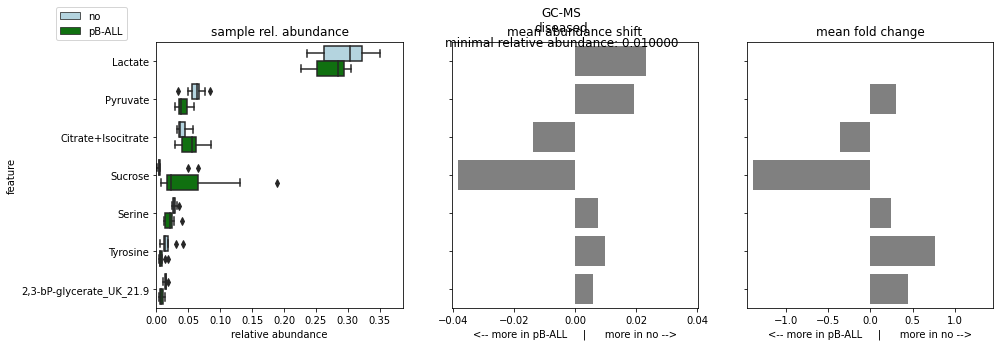

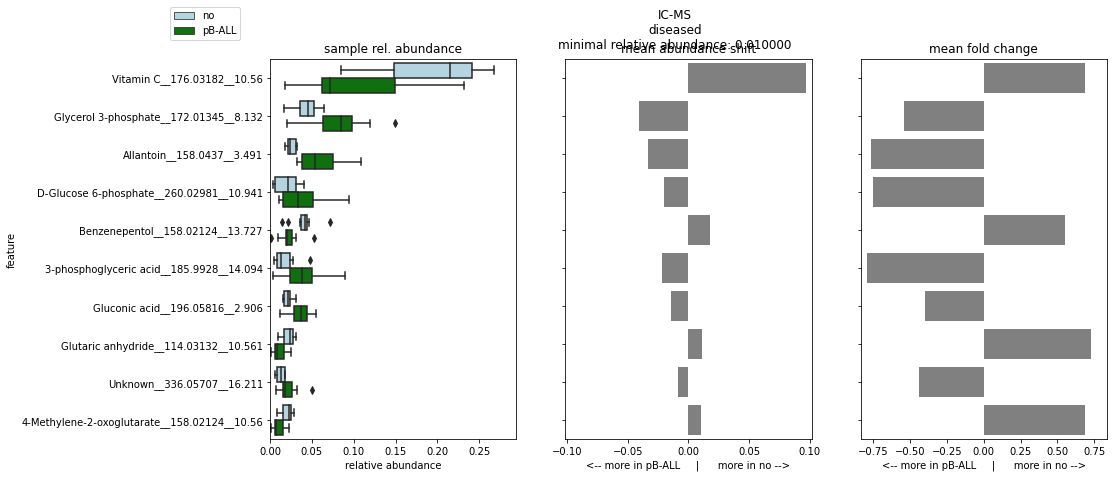

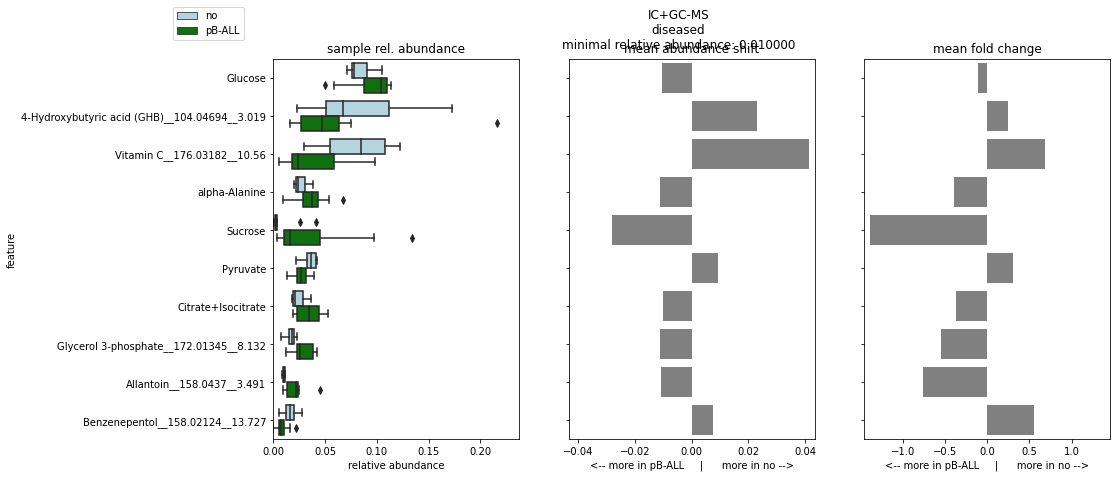

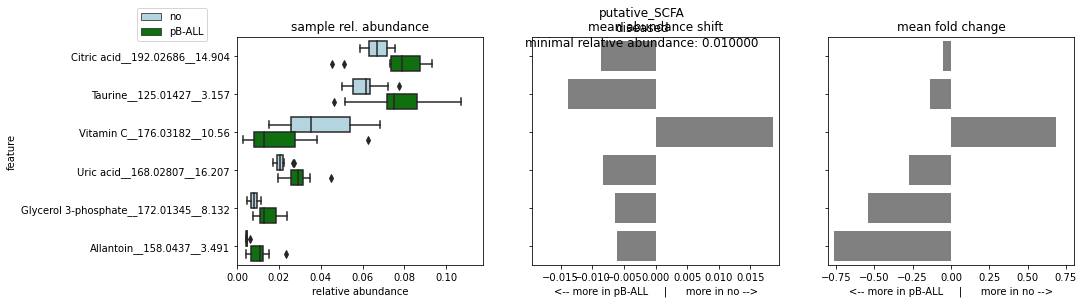

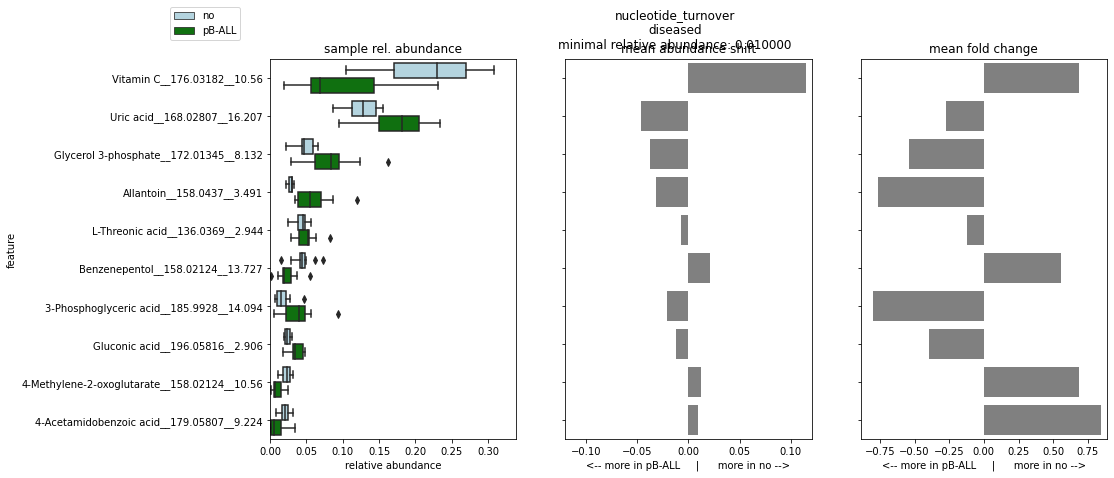

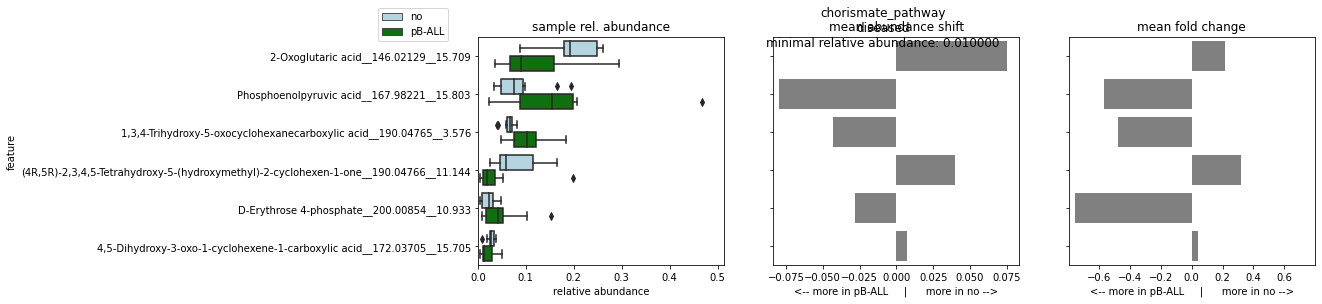

In [40]:
for method in res_beta.keys():
    field = 'diseased'
    res_dsFDR_diseased = find_diff_taxa(e[method], meta[meta['genotype'] == 'Pax5+/-'], [field])
    p = plot_diff_taxa(counts[method], meta[meta['genotype'] == 'Pax5+/-'][field], res_dsFDR_diseased, min_mean_abundance=0.01,
                       title=method, topXfeatures=10,
                       colors_boxplot={'no': 'lightblue', 'pB-ALL': 'green'}, color_barplot='gray')
    _savefig(p[0], 'metabolome_dsfdr_disease_%s' % method)
    found_compounds.extend([{'compound': x.get_text(), 'method': method, 'group': field, 'found': 1} for x in p[0].axes[0].get_yticklabels()])

In [41]:
list_compounds = pd.pivot_table(data=pd.DataFrame(found_compounds), index=('group', 'method'), columns='compound', values='found').T
list_compounds = list_compounds.loc[list_compounds.sum(axis=1).sort_values(ascending=False).index,:].applymap(lambda x: '' if np.isnan(x) else 'X')
list_compounds.to_excel('found_compunds.xlsx')
list_compounds

group                                              diseased                 \
method                                                GC-MS IC+GC-MS IC-MS   
compound                                                                     
Allantoin__158.0437__3.491                                         X     X   
Vitamin C__176.03182__10.56                                        X     X   
Glycerol 3-phosphate__172.01345__8.132                             X     X   
3,5-Dioxooctanedioic acid__202.04771__16.759                                 
Uric acid__168.02807__16.207                                                 
D-Glucose 6-phosphate__260.02981__10.941                                 X   
Gluconic acid__196.05816__2.906                                          X   
2,3-bP-glycerate_UK_21.9                                  X                  
3-Phosphoglyceric acid__185.9928__14.094                                     
3-phosphoglyceric acid__185.9928__14.094                                 X   
4-Methylene-2-oxoglutarate__158.02124__10.56                             X   
Benzenepentol__158.02124__13.727                                   X     X   
(-)-homoisocitric acid__206.04259__9.805                                     
Unknown__336.05707__16.211                                               X   
Sucrose                                                   X        X         
Unknown__264.04833__15.13                                                    
Citrate+Isocitrate                                        X        X         
D-Erythrose 4-phosphate__200.00854__10.933                                   
4,5-Dihydroxy-3-oxo-1-cyclohexene-1-carboxylic ...                           
D-Sedoheptulose 7-phosphate__290.04063__11.882                               
2-Oxoglutaric acid__146.02129__15.709                                        
2-Hydroxy-2-methylbutyric acid__118.06263__3.696                             
Taurine__125.01427__3.157                                                    
L-Threonic acid__136.0369__2.944                                             
Phosphoenolpyruvic acid__167.98221__15.803                                   
Pyruvate                                                  X        X         
hydroxyproline_UK_11.28                                                      
1,5-Anhydro-D-erythro-hexo-2,3-diulose__160.036...                           
alpha-Alanine                                                      X         
[Similar to: NP-016596; ΔMass: -146.2000 Da]__2...                           
1,3,4-Trihydroxy-5-oxocyclohexanecarboxylic aci...                           
(4R,5R)-2,3,4,5-Tetrahydroxy-5-(hydroxymethyl)-...                           
4-Acetamidobenzoic acid__179.05807__9.224                                    
4-Hydroxybutyric acid (GHB)__104.04694__3.019                      X         
Citric acid__192.02686__14.904                                               
Unknown__264.04832__14.729                                                   
Tyrosine                                                  X                  
Serine                                                    X                  
D-Glucose 6-phosphate__260.02973__8.226                                      
Tryptophan                                                                   
DL-Glyceric acid__106.02619__2.983                                           
DMPA_ISTD                                                                    
inositol-P_UK_18.537                                                         
Glucose                                                            X         
Glutaric anhydride__114.03132__10.561                                    X   
Isoleucine                                                                   
Lactate                                                   X                  
Methionine                                                                   
thymine_UK_9.988      

## Speculation about Chorismate Pathway

kegg
C00026   -0.709626
C00064   -0.415474
C00074    0.141000
C00279    0.838445
C00493   -0.403247
C00944   -0.442057
C02637   -1.061295
dtype: float64

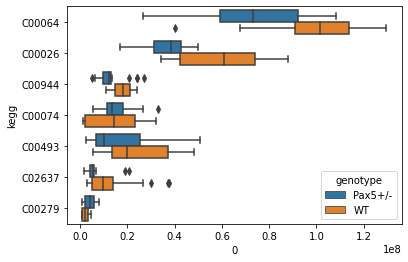

In [139]:
data = counts['chorismate_pathway'].stack().reset_index().merge(meta[meta['diseased'] == 'no']['genotype'], left_on="sample_name", right_index=True)
data['kegg'] = data['feature'].apply(lambda x: keggmap[x])
#display(data.head())
sns.boxplot(data=data, x=0, y='kegg', hue='genotype')

fc = data.groupby(['kegg', 'genotype'])[0].mean().unstack().reset_index().set_index('kegg')
fc = fc.apply(lambda x: np.log2(x['Pax5+/-'] / x['WT']), axis=1)
fc
#fc.reset_index()
#fc

#data = p[2].loc[['2-Oxoglutaric acid__146.02129__15.709'], :].T.merge(meta[meta['diseased'] == 'no']['genotype'], left_index=True, right_index=True)
#sns.boxplot(data=data, y='2-Oxoglutaric acid__146.02129__15.709', x='genotype', color='white')
#sns.swarmplot(data=data, y='2-Oxoglutaric acid__146.02129__15.709', x='genotype')

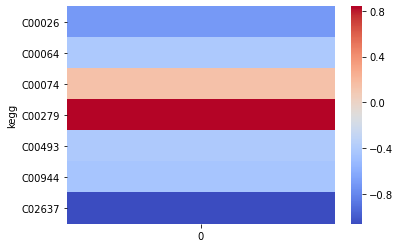

In [138]:
sns.heatmap(fc.to_frame(), cmap='coolwarm')